In [1]:
import sys
import os
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import audio_time_series_classification as preproject
import utility

sys.path.insert(1, module_path + '/src/models/')
import helper

from sklearn.decomposition import PCA
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.feature_selection import SelectKBest, chi2
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC

figure_path = module_path + '/figures/'

In [2]:
ts_path = module_path + '/data/ts_files/crackleNoCrackle_FULL.ts'
#NB ! This file has already been downsampled and denoised before saving
kwargs_ls = {
    'ts_file_path': ts_path,
    'sr' : 8000,
    'UCR_file': False,
    'n_mfcc' : 30,
    'denoise' : False,
    'downsample' : False,
    'downsample_new_sr' : 8000,
    'update' : False,
    'name' : 'lungsound',
    'module_path' : module_path
}

ls = preproject.overproduced_audio_time_series_features(**kwargs_ls)
X_train, X_test, y_train, y_test = ls.get_X_y_transformed(train_test_split = True)

pca = PCA(n_components = 100)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [12]:
from sklearn.metrics import accuracy_score, f1_score

def get_accuracy_accuracy_rejection_curve(y_test, y_pred, prob):  
    tot = len(y_test)
    def is_in_range(l, u, x):
        return (x < u) & (x > l)
    
    lower = np.linspace(0.5, 0, 101)[:-1]
    upper = np.linspace(0.5, 1, 101)[:-1]
    
    
    acc = []
    re = []
    

    for r in zip(lower, upper):
        temp_true = y_test.copy()
        temp_pred = y_pred.copy()
        
        reject_samples = is_in_range(r[0], r[1], prob)
        
        if np.any(reject_samples):
            keep_indices = np.where(reject_samples !=  True)[0]
            keep_indices = np.unique(keep_indices)

            temp_true = temp_true[keep_indices]
            temp_pred = temp_pred[keep_indices]
            
        #if len(acc)%10 == 0:
        #    f, ax = utility.plot_cm(temp_true, temp_pred, module_path = module_path)
            
        acc.append(accuracy_score(temp_true, temp_pred))
        re.append(1 - len(temp_true)/tot)
        
    return acc, re  

In [18]:
indices_0 = np.where(y_train.astype(int) == 0)[0]
indices_1 = np.where(y_train.astype(int) == 1)[0]
indices = np.concatenate((indices_0[0:1929], indices_1))

### SVM

In [23]:
clf = SVC(**{'C': 10, 'gamma': 1, 'kernel': 'rbf', 'probability' : True}).fit(X_train[indices], y_train[indices])

y_pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)

a_svm, r_svm = get_accuracy_accuracy_rejection_curve(y_test, y_pred, prob)

/home/andrine/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/andrine/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Gaussian Process classifier

In [21]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

X_train, X_test, y_train, y_test = ls.get_X_y_transformed(train_test_split = True)

pca = PCA(n_components = 10)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train[indices], y_train[indices])

y_pred = gpc.predict(X_test)
prob = gpc.predict_proba(X_test)

a_gp, r_gp = get_accuracy_accuracy_rejection_curve(y_test, y_pred, prob)

/home/andrine/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/andrine/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Logistic Regression Classifier

In [24]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = ls.get_X_y_transformed(train_test_split = True)

pca = PCA(n_components = 100)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

clf = LogisticRegression(random_state=0).fit(X_train[indices], y_train[indices])

y_pred = clf.predict(X_test)
prob = clf.predict_proba(X_test)

a_lr, r_lr = get_accuracy_accuracy_rejection_curve(y_test, y_pred, prob)

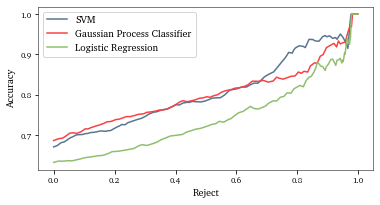

In [30]:
from matplotlib.font_manager import FontProperties

figure_path = module_path + '/figures/'
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

f, ax = plt.subplots(1,1)
f.set_size_inches(6, 3)
ax.plot(r_svm, a_svm, c = colors[2], label = 'SVM')
ax.plot(r_gp, a_gp, c = colors[0], label = 'Gaussian Process Classifier')
ax.plot(r_lr, a_lr, c = colors[1], label = 'Logistic Regression')
ax.set_ylabel('Accuracy', fontproperties = font)
ax.set_xlabel('Reject', fontproperties = font)
for label in ax.get_yticklabels() :
    label.set_fontproperties(font_small)
for label in ax.get_xticklabels() :
    label.set_fontproperties(font_small)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
    
ax.legend(prop = font)

plt.savefig(figure_path + 'accuracy_rejection_ex.pdf', bbox_inches='tight')